# Курсовой проект для курса "Python для Data Science"

### Задание:

Задача в этом соревновании - предсказать цены на квартиры в датасете `test.csv`. Вам будут даны два датасета: `train.csv` (содержит признаки и цены на квартиры) и `test.csv` (только признаки).


### Целевая переменная:

`Price`

### Метрика качества

`R2` - коэфициент детерминации `sklearn.metrics.r2_score`


### Описание датасета:

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

### Пути к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'sample_submission.csv '

### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
def reduce_mem_usage(train_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Обзор обучающего датасета

In [7]:
train_df.shape

(10000, 20)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Определяем пропуски

Мне показался такой способ самым удобным (визуально) для оценки пропусков. Желтые - пропуски. Синие - норма

<AxesSubplot:>

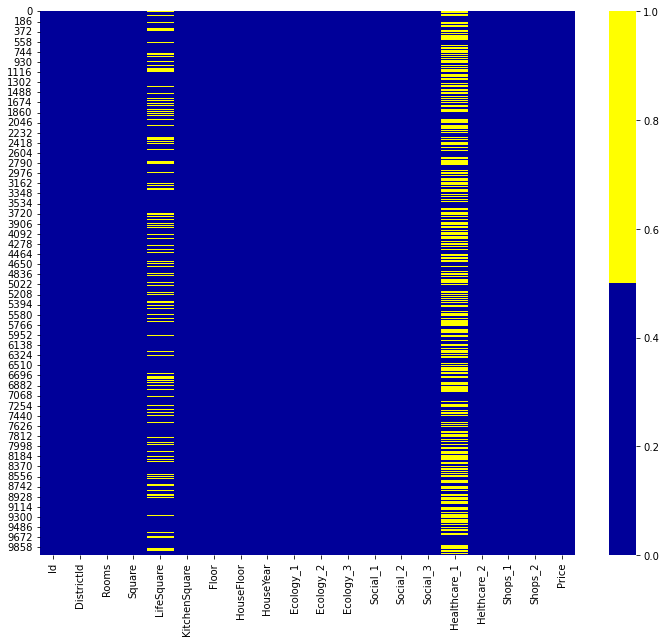

In [10]:
cols = train_df.columns[:20] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенныес
colours = ['#000099', '#ffff00'] 
plt.figure(figsize=(12,10))
sns.heatmap(train_df[cols].isnull(), cmap=sns.color_palette(colours))

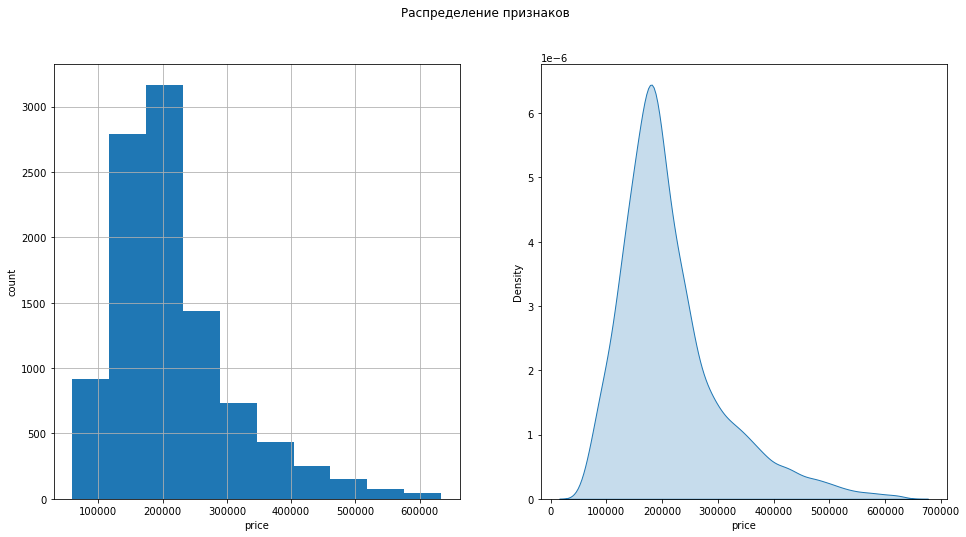

In [11]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение признаков')
plt.show()

### Готовлю датасет к обучению

Я обратил внимание на признак "Healthcare_1", т.к. по нему почти **50%** пропусков решено его исключить

In [12]:
train_df = train_df.drop('Healthcare_1', axis=1)

Так же категориальные признаки `Ecology_2`, `Ecology_3`, `Shops_2` переделаю в бинарные

In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [16]:
# Преобразуем с помощью replace
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Поработаю с выбросами `Rooms`

In [17]:
rooms_median = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_median

И с выбросами признаков `LifeSquare` и `KitchenSquare`

In [18]:
lifesq_median = train_df['LifeSquare'].median()
kitchsq_median = train_df['KitchenSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_median
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_median
train_df.loc[train_df['LifeSquare'] > 400, 'LifeSquare'] = lifesq_median
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_median
train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_median

Поработаю с выбросами признака `Square`

In [19]:
square_median = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_median
train_df.loc[train_df['Square'] > 400, 'Square'] = square_median

Поработаю с выбросами признака `HouseYear`

In [20]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Поработаю с выбросами признаков `Floor` и `HouseFloor`

In [21]:
hfloor_median = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_median

In [22]:
ind = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind, 'Floor'] = train_df.loc[ind, 'HouseFloor']

Вычислю `m_2_Price` - стоимость квадратного метра общей площади

In [23]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']

На его основе создам новые признаки `m_2_MedPriceByDistrict` - медианная стоимость квадратного метра в зависимости от района и `m_2_MedPriceByHouseYear` - медианная стоимость квадратного метра в зависимости от возраста дома

In [24]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

Добавлю новые признаки к датасету

In [25]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,1,1,1,2651.708272,2759.086353,2793.739365
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,1,1,1,4462.045990,3553.678687,4376.488083
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,1,1,1,3600.596698,3251.647396,4447.681698
3,2352,1,1.0,40.409907,32.781260,6.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,1,1,1,4160.019670,3251.647396,2901.326376
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,1,1,1,5351.088794,4219.992382,4285.794408


In [26]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,56.228457,35.980607,7.490600,7.918200,12.95910,1984.872400,0.118858,...,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3891.739716,3927.295723,3780.144330
std,4859.01902,43.587592,0.812096,19.058793,15.378518,3.290409,5.186386,6.44346,18.416347,0.119025,...,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1251.728243,997.479341,762.735269
min,0.00000,0.000000,1.000000,16.117154,10.523868,5.000000,1.000000,1.00000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2273.498737,2764.147132
25%,4169.50000,20.000000,1.000000,41.800063,27.654813,6.000000,4.000000,9.00000,1974.000000,0.017647,...,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2916.973642,2938.048239,2901.326376
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.00000,1977.000000,0.075424,...,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3907.999942,4134.353749,4285.794408
75%,12592.50000,75.000000,2.000000,65.889736,41.415441,9.000000,11.000000,17.00000,2001.000000,0.195781,...,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4690.526670,4562.026777,4409.376396
max,16798.00000,209.000000,6.000000,275.645284,263.542020,78.000000,42.000000,117.00000,2020.000000,0.521867,...,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11854.652892,8700.768533,7823.822055


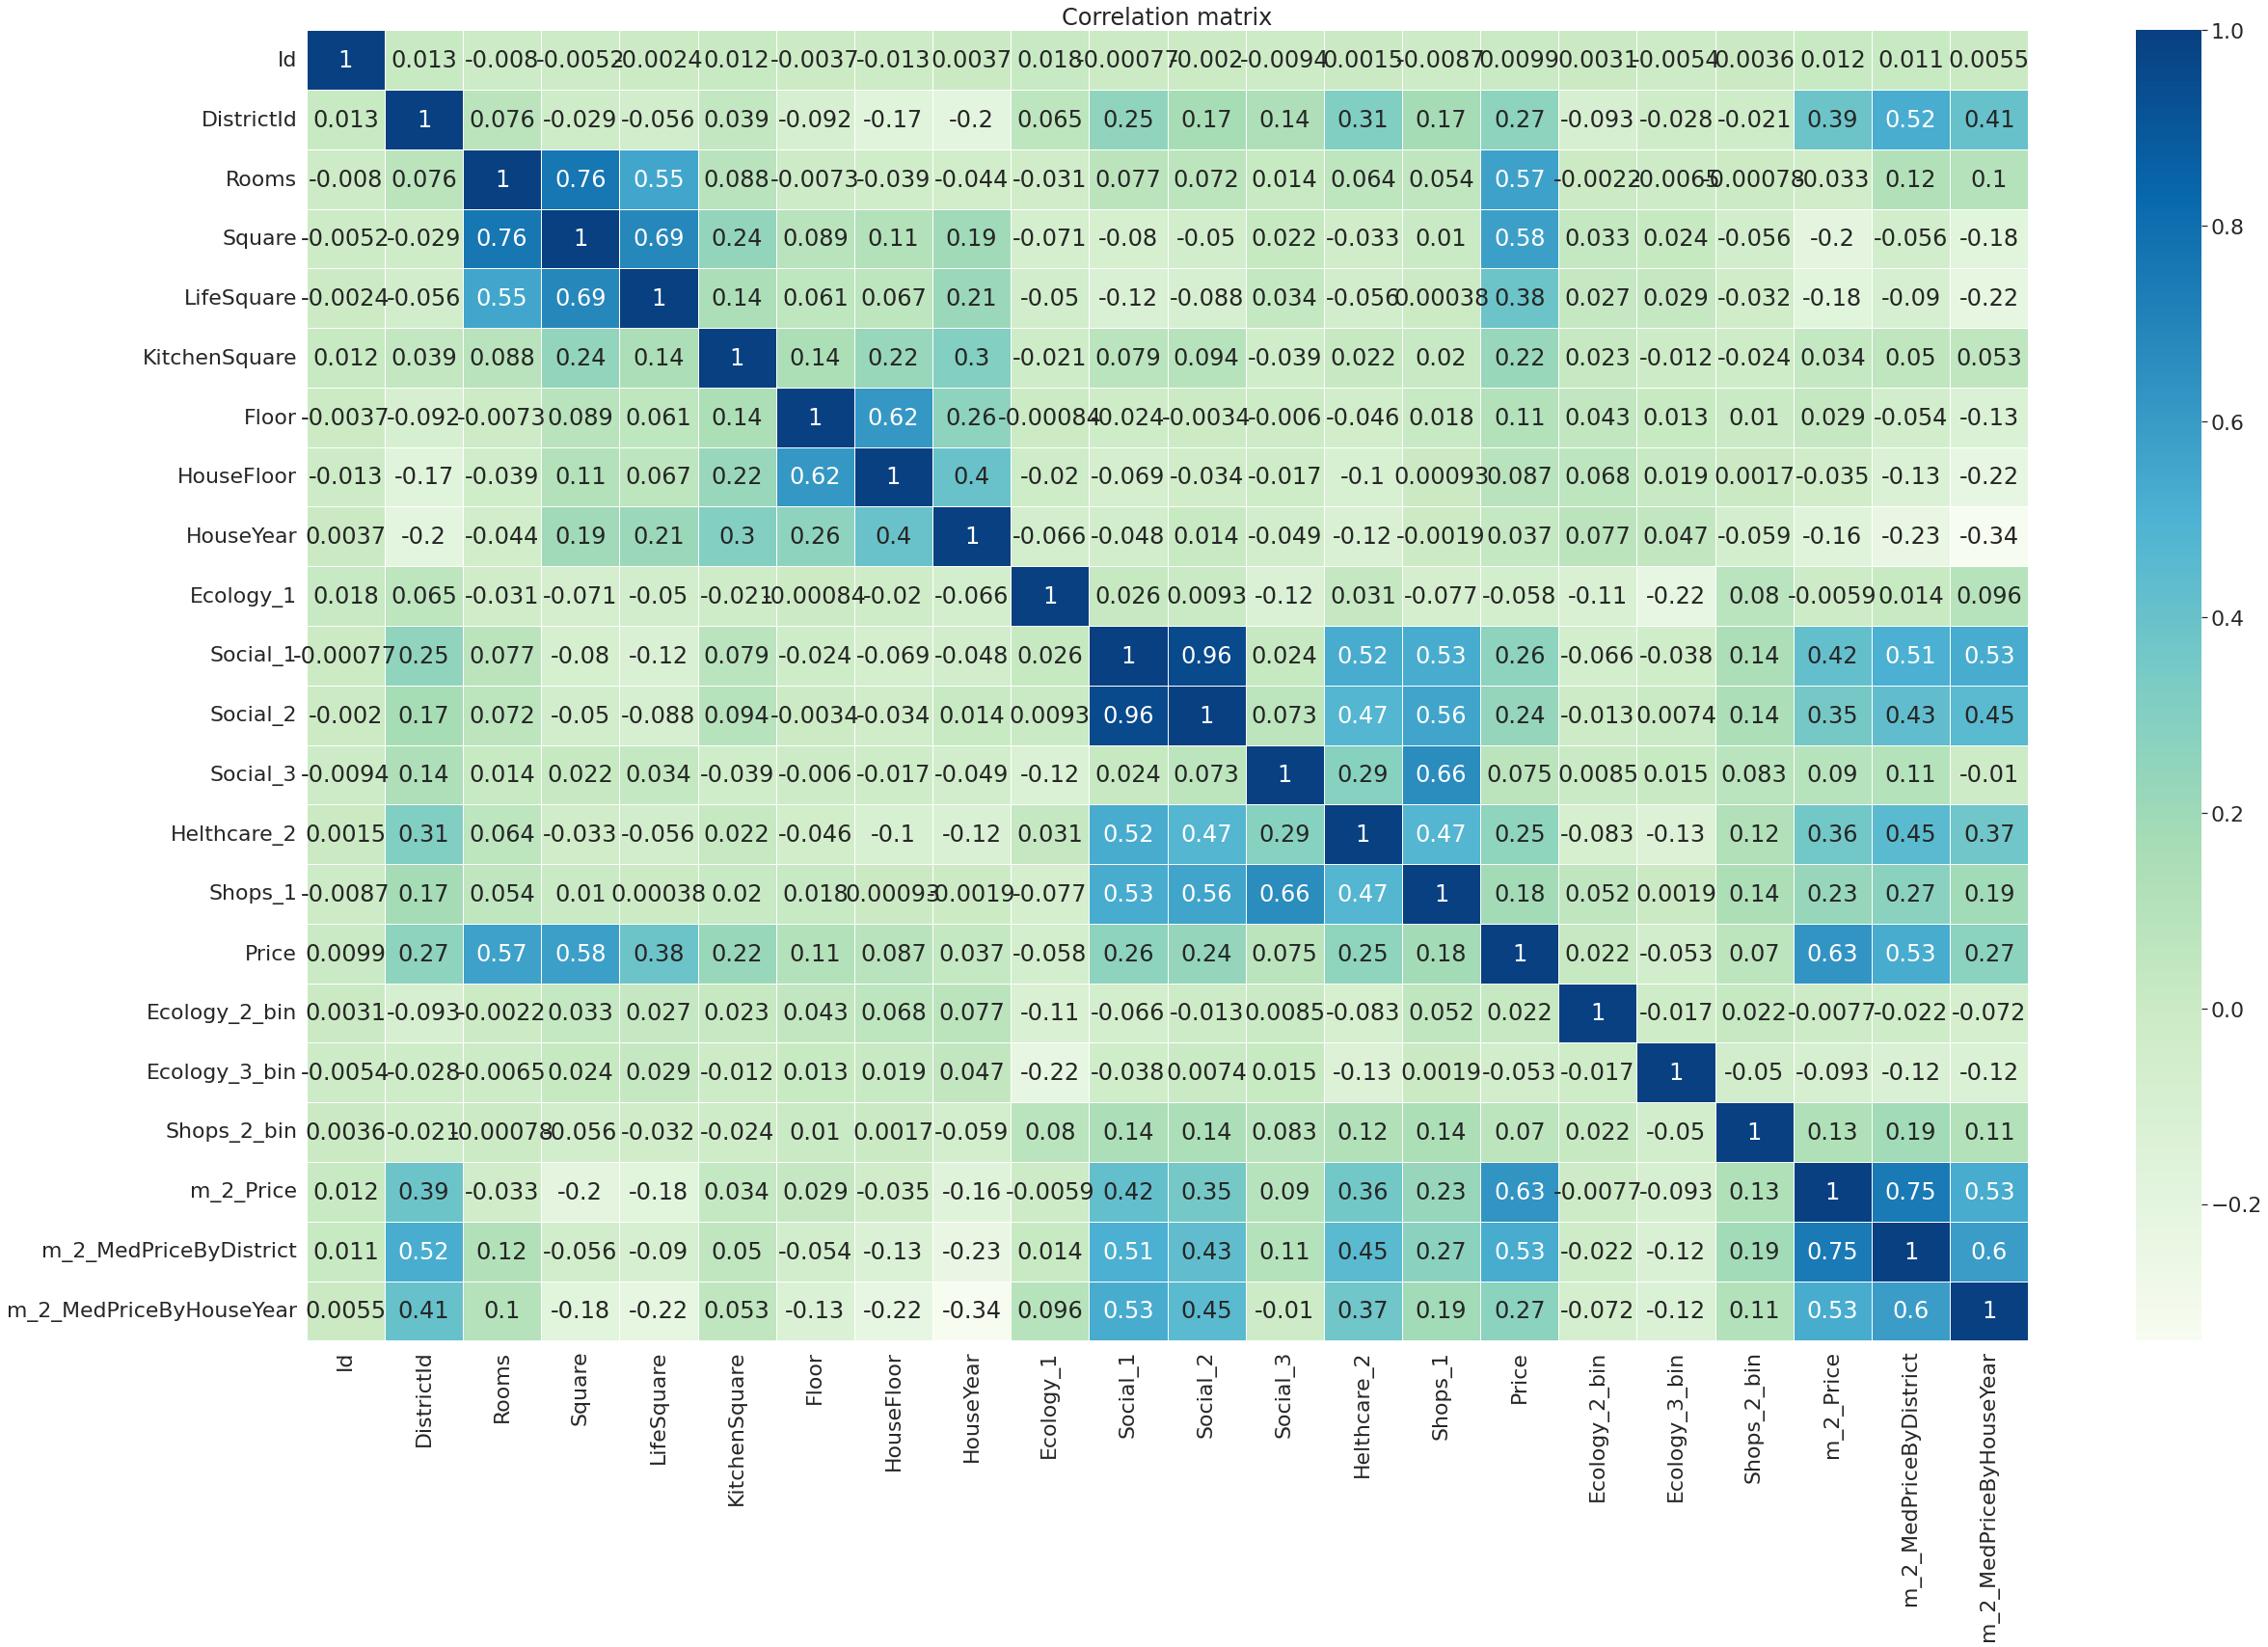

In [27]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Отбираю признаки для модели

In [28]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [29]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,3.0,115.027311,32.781260,10.0,4,10.0,2014,2759.086353,2793.739365,0.075424,11,0,0,0,1,1,1,305018.871089
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,3553.678687,4376.488083,0.118537,30,1,1,0,1,1,1,177734.553407
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,3251.647396,4447.681698,0.025609,33,0,3,1,1,1,1,282078.720850
3,1.0,40.409907,32.781260,6.0,10,22.0,1977,3251.647396,2901.326376,0.007122,1,0,0,1,1,1,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,4219.992382,4285.794408,0.282798,33,2,0,6,1,1,1,343995.102962


Масштабирую признаки

In [30]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [31]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,1.368379,3.085284,-0.208050,0.762679,-0.755516,-0.459264,1.581696,-1.171220,-1.293311,-0.364931,-0.780698,-0.337347,-0.883480,-0.880402,0.09897,0.16816,0.299864,305018.871089
1,-1.094506,-0.860325,-0.833112,0.154821,-0.177049,-0.769672,-1.024815,-0.374580,0.781888,-0.002690,0.303050,-0.295384,-0.213923,-0.880402,0.09897,0.16816,0.299864,177734.553407
2,1.368379,1.160350,0.760278,0.762679,-1.141160,0.627163,0.169836,-0.677390,0.875233,-0.783473,0.474169,-0.337347,1.125190,-0.672333,0.09897,0.16816,0.299864,282078.720850
3,-1.094506,-0.830028,-0.208050,-0.453036,0.401417,1.403183,-0.427489,-0.677390,-1.152250,-0.938799,-1.351093,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,168106.007630
4,0.136936,0.422745,0.167899,0.458750,1.558350,0.471959,-0.699001,0.293451,0.662976,1.377425,0.474169,-0.253421,-0.883480,0.368011,0.09897,0.16816,0.299864,343995.102962


Разбиваю на обучающую и валидационную выборку

In [32]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

Строю и обучаю модель

In [33]:
gb_model = GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

R2:	0.915


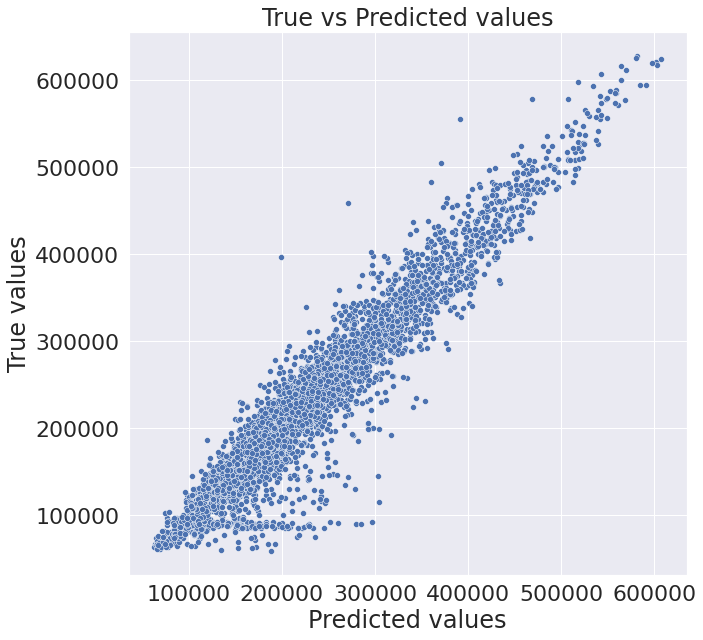

In [34]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

Проверка на валидационной выборке

R2:	0.733


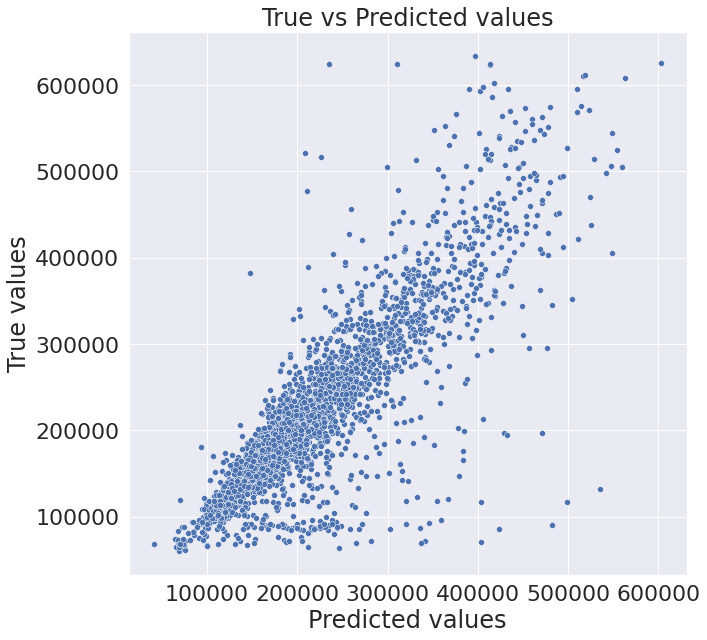

In [35]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

Важность признаков

In [36]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.432644
7,m_2_MedPriceByDistrict,0.383839
8,m_2_MedPriceByHouseYear,0.039527
0,Rooms,0.023529
2,LifeSquare,0.019898
5,HouseFloor,0.019602
10,Social_1,0.017974
6,HouseYear,0.014518
9,Ecology_1,0.012616
3,KitchenSquare,0.009812


Обзор тестового датасета

In [37]:
test_df.shape

(5000, 19)

In [38]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [39]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Подготовка тестового датасета

<AxesSubplot:>

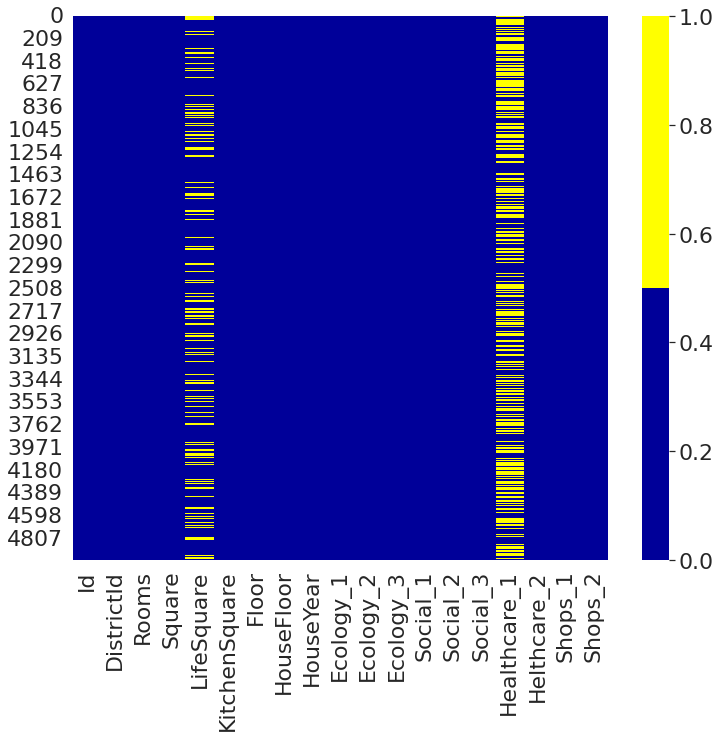

In [40]:
cols = test_df.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенныес
colours = ['#000099', '#ffff00'] 
plt.figure(figsize=(12,10))
sns.heatmap(test_df[cols].isnull(), cmap=sns.color_palette(colours))

Исключаю признак "Healthcare_1", т.к. по нему почти 50% пропусков

In [41]:
test_df = test_df.drop('Healthcare_1', axis=1)

Преобразую категориальные признаки `Ecology_2`, `Ecology_3`, `Shops_2` в бинарные

In [42]:
test_df['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [43]:
test_df['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [44]:
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [45]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

Работаю с выбросами признака `Rooms`


In [46]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = rooms_median

Работаю с выбросами признаков `LifeSquare` и `KitchenSquare`

In [47]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_median
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_median
test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_median
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_median
test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_median

Работаю с выбросами признака `Square`

In [48]:
test_df.loc[test_df['Square'] < 16, 'Square'] = square_median
test_df.loc[test_df['Square'] > 400, 'Square'] = square_median

Работаю с выбросами признаков `Floor` и `HouseFloor`

In [49]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_median

In [50]:
ind = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind, 'Floor'] = test_df.loc[ind, 'HouseFloor']

Добавляю новые признаки к датасету

In [51]:
test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

Заполняю возможные пропуски

In [52]:
test_df.loc[test_df['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] =\
                    m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()

In [53]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] < 1950), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] < 1950,
                                                  'm_2_MedPriceByHouseYear'].median()

In [54]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1990), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] >= 1990,
                                                  'm_2_MedPriceByHouseYear'].median()

In [55]:
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1950) &\
                    (test_df['HouseYear'] < 1990), 'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[(m_2_MedPriceByHouseYear['HouseYear'] >= 1950) & \
                                                  (m_2_MedPriceByHouseYear['HouseYear'] < 1990),
                                                  'm_2_MedPriceByHouseYear'].median()

In [56]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.90780,56.543749,36.047463,7.425800,8.054000,12.941600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.990400,0.970200,0.917600,3946.750805,3790.421605
std,4832.674037,44.179466,0.81008,18.955344,14.706864,3.038674,5.337076,6.466881,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.097518,0.170052,0.275001,985.494228,761.818482
min,1.000000,0.000000,1.00000,16.319015,10.692499,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2273.498737,2793.739365
25%,4221.750000,21.000000,1.00000,41.951045,27.990919,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,2949.975415,2901.326376
50%,8320.500000,37.000000,2.00000,52.921340,32.781260,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,1.000000,1.000000,1.000000,4158.187979,4285.794408
75%,12598.250000,77.000000,2.00000,66.285129,41.760597,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,1.000000,1.000000,1.000000,4571.660177,4409.376396
max,16795.000000,212.000000,6.00000,223.453689,169.901701,65.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,1.000000,8700.768533,7823.822055


Масштабирую признаки

In [57]:
stand_features = scaler.fit_transform(test_df[feature_names])

In [58]:
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

Предсказываю цены для тестового датасета

In [59]:
X_test = test_df[feature_names]

In [60]:
y_test_preds = gb_model.predict(X_test)

Сохраняю результаты


In [61]:
test_df['Price'] = y_test_preds

In [62]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')